In [2]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [3]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [4]:
#Load shapefile

my_shapefile_path = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
my_shp = gpd.read_file(my_shapefile_path)
#print(my_shp)

In [5]:
#Access to Mapillary API

clienttoken = 
clientsecret = 
#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)


                    ID                   geometry
0     1245720132514659  POINT (12.54524 55.66963)
1     1267648453690660  POINT (12.56263 55.67421)
2     1353834688323369  POINT (12.54288 55.66401)
3     1406723733023964  POINT (12.55011 55.67269)
4     2924540581162264  POINT (12.55190 55.66445)
...                ...                        ...
1980  1260996954764990  POINT (12.55927 55.66557)
1981  2949243825353786  POINT (12.55744 55.66514)
1982  1490141294489778  POINT (12.56082 55.66277)
1983  1589451517914588  POINT (12.55001 55.67257)
1984  1684506568553582  POINT (12.55861 55.66800)

[1985 rows x 2 columns]


In [6]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

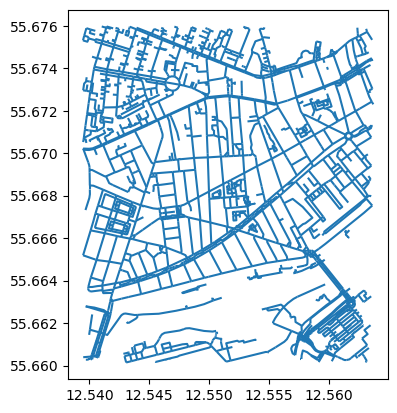

In [7]:

df_lines["geometry"].plot()

/tmp/ipykernel_131955/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

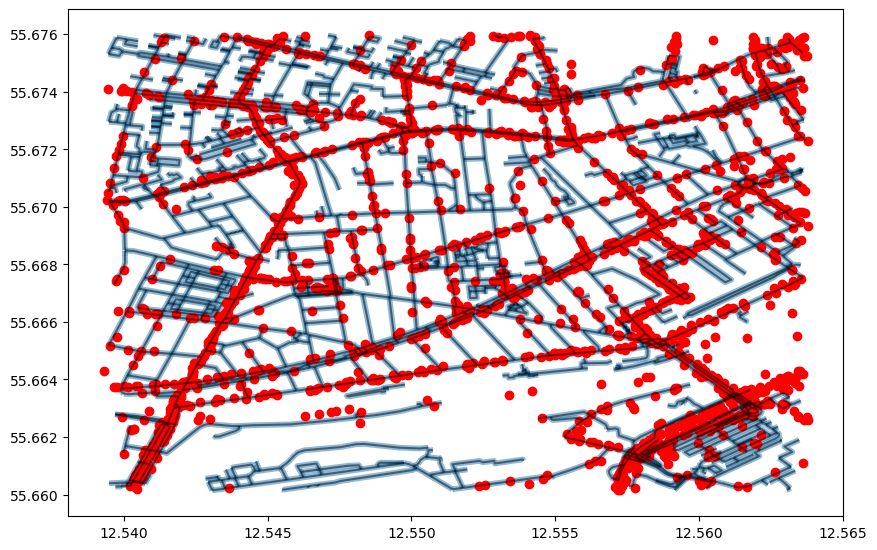

In [8]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_131955/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_131955/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


299


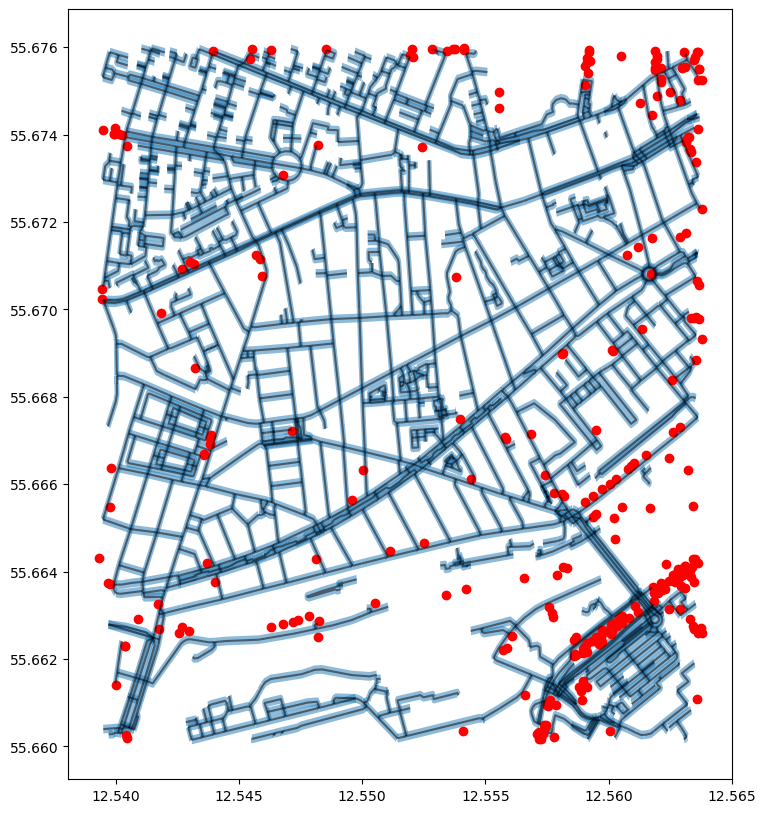

In [9]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [10]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1245720132514659,POINT (12.54524 55.66963),290027.0,174474070.0
1,1267648453690660,POINT (12.56263 55.67421),249109.0,174477316.0
2,1353834688323369,POINT (12.54288 55.66401),230219.0,174472811.0
3,1406723733023964,POINT (12.55011 55.67269),60925.0,174476056.0
3,1406723733023964,POINT (12.55011 55.67269),77327.0,174476062.0
...,...,...,...,...
1982,1490141294489778,POINT (12.56082 55.66277),277030.0,174475581.0
1983,1589451517914588,POINT (12.55001 55.67257),60925.0,174476056.0
1983,1589451517914588,POINT (12.55001 55.67257),77327.0,174476062.0
1984,1684506568553582,POINT (12.55861 55.66800),25792.0,174476771.0


<Axes: >

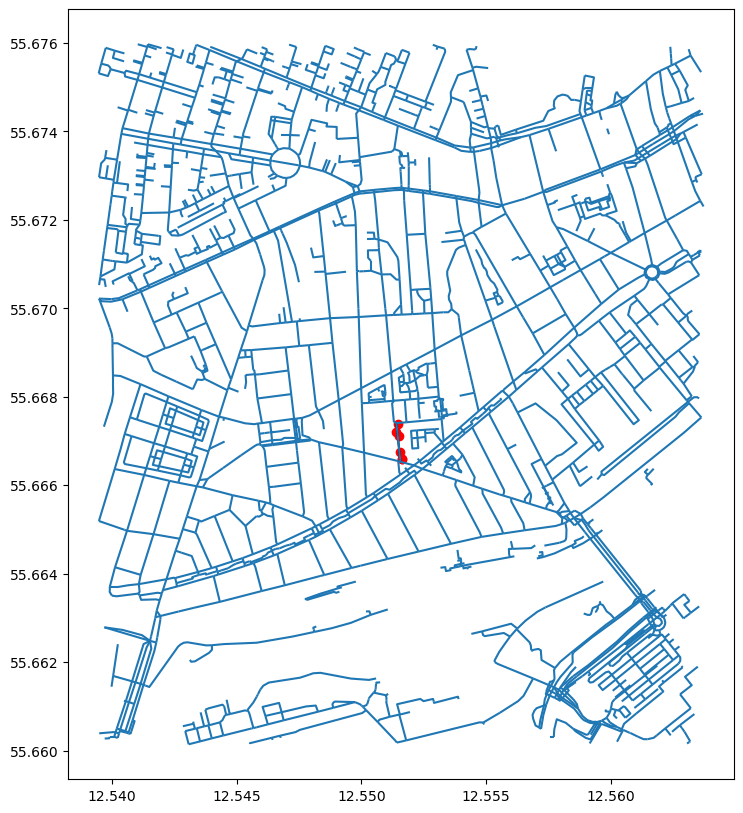

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

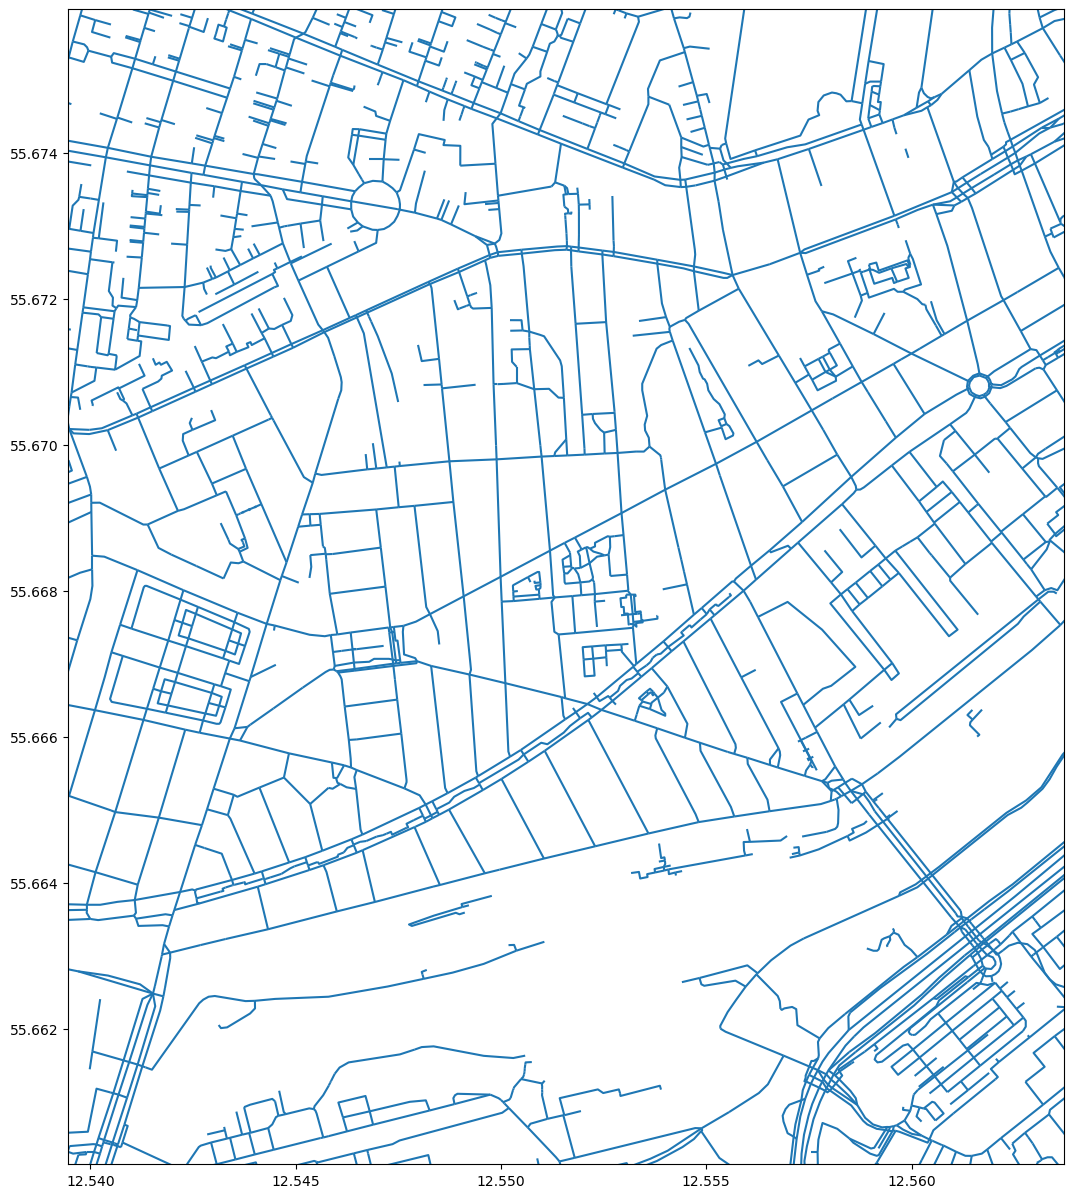

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [13]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214613/data/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [14]:

#print(strava_csv)

csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("sum")
collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))

print(activity_df)


(1901, 2442)
                ID  Activity
3552     174476152      1260
4284     174476138       725
5205     174472857     11885
5217     174475361     11190
6086     174474204      5855
...            ...       ...
1662088  174475728     11890
1662100  174476604     10050
1664757  174474907       565
1665491  174474571      4670
1665515  174476242      2935

[1901 rows x 2 columns]


In [15]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1245720132514659,POINT (12.54524 55.66963),290027.0,174474070.0,174474070,865
1,4083854151719184,POINT (12.54536 55.66943),290027.0,174474070.0,174474070,865
2,1472036279845514,POINT (12.54541 55.66951),290027.0,174474070.0,174474070,865
3,1404551193248616,POINT (12.54539 55.66951),290027.0,174474070.0,174474070,865
4,1267648453690660,POINT (12.56263 55.67421),249109.0,174477316.0,174477316,1045
...,...,...,...,...,...,...
2453,3263462750650778,POINT (12.55812 55.66134),53152.0,174475326.0,174475326,685
2454,3263462750650778,POINT (12.55812 55.66134),201849.0,174475325.0,174475325,2460
2455,3787663937948974,POINT (12.54804 55.67498),121513.0,174476276.0,174476276,1365
2456,1458170157867561,POINT (12.54587 55.66744),264432.0,174472981.0,174472981,8410


In [16]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [17]:
'''
result = merged_df.drop_duplicates(['ID_left'],keep='first')
result
reset = result.reset_index()
reset.pop("index")
reset
#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)
#print(dataframe2)
'''

'\nresult = merged_df.drop_duplicates([\'ID_left\'],keep=\'first\')\nresult\nreset = result.reset_index()\nreset.pop("index")\nreset\n#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)\n#print(dataframe2)\n'

In [23]:
list_image_id = merged_df["ID_left"].to_list()
list_image_id_new = list_image_id[0:9]
list_image_id_new = [eval(i) for i in list_image_id_new]
list_image_id = [eval(i) for i in list_image_id]
#print(list_image_id_new)

clienttoken = 
clientsecret = 
#URL for getting only images within the chosen boundaries


ID_image = []
detection = []

for i in range(0,len(list_image_id_new)):
    url = f"https://graph.mapillary.com/{list_image_id_new[i]}/detections?access_token={clienttoken}&fields=image,value"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid of bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    #print(len(images))
    #print(images)
    for i in range(0,len(images)):
        try:
            val = str(images[i]["value"])
            detection.append(val)
            ID = str(images[i]["image"]["id"])
            ID_image.append(ID)
        except KeyError:
            continue


            
#list of objects to remove 
vd = ["void--dynamic","void--static","void--unlabeled"]

indices_to_remove = [i for i, string in enumerate(detection) if string in vd]

new_string_list = []
new_index_list = []
for i in range(len(detection)):
    if i not in indices_to_remove:
        new_string_list.append(detection[i])
        new_index_list.append(ID_image[i])
    



print((len(new_index_list),len(new_string_list)))
dataframevalue = {"ID": new_index_list, "Detection": new_string_list}
df_imagess = gpd.GeoDataFrame(dataframevalue)
print(df_imagess)
            
dict_image = df_imagess.groupby('ID')['Detection'].agg(list).to_dict()
print(dict_image)





(666, 666)
                   ID                                  Detection
0    4083854151719184      construction--barrier--concrete-block
1    4083854151719184                construction--barrier--curb
2    4083854151719184      construction--barrier--concrete-block
3    4083854151719184                construction--barrier--curb
4    4083854151719184                construction--barrier--curb
..                ...                                        ...
661  1539216236588768             marking--discrete--arrow--left
662  1539216236588768  object--traffic-sign--information-parking
663  1539216236588768                      object--support--pole
664  1539216236588768                 regulatory--keep-right--g1
665  2939344836341326        regulatory--pass-on-either-side--g1

[666 rows x 2 columns]
{'1267648453690660': ['regulatory--pass-on-either-side--g1'], '1404551193248616': ['regulatory--shared-path-pedestrians-and-bicycles--g1', 'information--parking--g2', 'regulatory--no-st